In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/EURGBP.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-01,0.6547,0.6547,0.6497,0.6504,0.6504,0.0
1,2003-01-02,0.6503,0.6627,0.6475,0.6494,0.6494,0.0
2,2003-01-03,0.6496,0.6516,0.6466,0.6472,0.6472,0.0
3,2003-01-06,0.6471,0.6523,0.6467,0.6502,0.6502,0.0
4,2003-01-07,0.6498,0.6510,0.6477,0.6490,0.6490,0.0


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4430,2019-12-25,0.85700,0.86070,0.84913,0.85700,0.85700,0.0
4431,2019-12-26,0.85520,0.85550,0.85290,0.85530,0.85530,0.0
4432,2019-12-27,0.85370,0.85632,0.85095,0.85380,0.85380,0.0
4433,2019-12-30,0.85406,0.85558,0.85128,0.85406,0.85406,0.0
4434,2019-12-31,0.85419,0.85480,0.84544,0.85426,0.85426,0.0


In [5]:
data = data.dropna()
data.isnull().values.any()

False

In [6]:
test_frac = 0.1
split = len(data) - round(test_frac*len(data))
#split
df_train = data[:split]
df_test = data[split:]

In [7]:
print(len(df_train))
print(len(df_test))

3965
441


In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#sc = MinMaxScaler()
sc = StandardScaler()
df_train_scale = sc.fit_transform(df_train['Close'].values.reshape(-1,1))
df_test_scale = sc.transform(df_test['Close'].values.reshape(-1,1))

In [9]:
df_train_scale

array([[-1.61547514],
       [-1.6276607 ],
       [-1.65446891],
       ...,
       [ 1.09641972],
       [ 1.09958796],
       [ 1.09934425]])

In [10]:
input_time_step = 16
output_time_step = [2,3,5,7,10]
epoch = 1000
batch_size = 32
validation_split=0.1
optimizer = 'adam'
loss = 'mean_squared_error'
dropout = 0.1
lstm_units = 100
callback = EarlyStopping(monitor = 'val_loss', 
                         min_delta = 1e-4, 
                         patience = 100, 
                         verbose=1, 
                         mode='auto', 
                         restore_best_weights=True)
RMSE = []
MAE = []

In [11]:
for step in output_time_step:
    
    # Creating supervised dataset
    in_start = 0
    x_train = []
    y_train = []
    for i in range(len(df_train_scale)):
        in_end = in_start + input_time_step
        out_end = in_end + step
        if out_end < len(df_train_scale):
            x_train.append(df_train_scale[in_start:in_end, 0])
            y_train.append(df_train_scale[in_end:out_end, 0])
        in_start += 1
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    print(x_train.shape)
    print(y_train.shape)
    
    # Vanilla LSTM Model
    model = Sequential()
    model.add(LSTM(units = lstm_units,input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(step))
    model.compile(optimizer = optimizer, loss = loss)
    
    # Training Model
    history = model.fit(x_train, 
                        y_train,
                        validation_split = validation_split,
                        callbacks = [callback], 
                        epochs = epoch, 
                        batch_size = batch_size, 
                        shuffle = False)
    
    
    # Prediction on Test Set
    pred_vector = np.empty((0, step))
    real_vector = np.empty((0, step))

    for i in range(df_test_scale.size):

        if(i+step+input_time_step < df_test_scale.size): 
            val = df_test_scale[i:i+input_time_step]
            #print(i, i+input_time_step)
            val = val.reshape((1, len(val), 1))
            #print(val.shape)
            pred = model.predict(val)
            pred = sc.inverse_transform(pred)
            pred_vector = np.append(pred_vector,pred,axis=0)
            real = df_test_scale[i+input_time_step:i+input_time_step+step].reshape(1,step)
            #print(i+input_time_step,i+input_time_step+output_time_step)
            real = sc.inverse_transform(real)
            real_vector = np.append(real_vector,real,axis=0)
        else:
            break
    
    print(pred_vector.shape)
    print(real_vector.shape)
    
    # Calculate Accuracy
    sum_mae = 0
    sum_rmse = 0
    for i in range(len(pred_vector)):#same as real_vector
        mae = metrics.mean_absolute_error(real_vector[i], pred_vector[i])
        mse = metrics.mean_squared_error(real_vector[i], pred_vector[i])
        rmse = np.sqrt(mse)
        sum_mae = sum_mae + mae
        sum_rmse = sum_rmse + rmse

    # Average MAE
    avg_mae = sum_mae / len(pred_vector)
    # Average RMSE
    avg_rmse = sum_rmse / len(pred_vector)
    
    RMSE.append(avg_rmse)
    MAE.append(avg_mae)

(3947, 16, 1)
(3947, 2)
Train on 3552 samples, validate on 395 samples
Epoch 1/1000
3552/3552 [==============================] - 1s 353us/step - loss: 0.0934 - val_loss: 0.0432
Epoch 2/1000
3552/3552 [==============================] - 1s 239us/step - loss: 0.0231 - val_loss: 0.0183
Epoch 3/1000
3552/3552 [==============================] - 1s 237us/step - loss: 0.0196 - val_loss: 0.0120
Epoch 4/1000
3552/3552 [==============================] - 1s 236us/step - loss: 0.0170 - val_loss: 0.0161
Epoch 5/1000
3552/3552 [==============================] - 1s 233us/step - loss: 0.0153 - val_loss: 0.0187
Epoch 6/1000
3552/3552 [==============================] - 1s 245us/step - loss: 0.0143 - val_loss: 0.0179
Epoch 7/1000
3552/3552 [==============================] - 1s 250us/step - loss: 0.0132 - val_loss: 0.0126
Epoch 8/1000
3552/3552 [==============================] - 1s 236us/step - loss: 0.0131 - val_loss: 0.0113
Epoch 9/1000
3552/3552 [==============================] - 1s 230us/step - loss: 0

Epoch 77/1000
3552/3552 [==============================] - 2s 453us/step - loss: 0.0058 - val_loss: 0.0044
Epoch 78/1000
3552/3552 [==============================] - 2s 445us/step - loss: 0.0058 - val_loss: 0.0044
Epoch 79/1000
3552/3552 [==============================] - 2s 423us/step - loss: 0.0058 - val_loss: 0.0044
Epoch 80/1000
3552/3552 [==============================] - 2s 437us/step - loss: 0.0059 - val_loss: 0.0044
Epoch 81/1000
3552/3552 [==============================] - 1s 390us/step - loss: 0.0060 - val_loss: 0.0046
Epoch 82/1000
3552/3552 [==============================] - 2s 498us/step - loss: 0.0060 - val_loss: 0.0044
Epoch 83/1000
3552/3552 [==============================] - 2s 439us/step - loss: 0.0057 - val_loss: 0.0043
Epoch 84/1000
3552/3552 [==============================] - 2s 468us/step - loss: 0.0056 - val_loss: 0.0046
Epoch 85/1000
3552/3552 [==============================] - 2s 446us/step - loss: 0.0059 - val_loss: 0.0045
Epoch 86/1000
3552/3552 [============

3552/3552 [==============================] - 2s 438us/step - loss: 0.0057 - val_loss: 0.0044
Epoch 154/1000
3552/3552 [==============================] - 2s 428us/step - loss: 0.0056 - val_loss: 0.0045
Epoch 155/1000
3552/3552 [==============================] - 1s 413us/step - loss: 0.0058 - val_loss: 0.0044
Epoch 156/1000
3552/3552 [==============================] - 1s 406us/step - loss: 0.0055 - val_loss: 0.0044
Epoch 157/1000
3552/3552 [==============================] - 1s 422us/step - loss: 0.0057 - val_loss: 0.0044
Epoch 158/1000
3552/3552 [==============================] - 1s 409us/step - loss: 0.0058 - val_loss: 0.0044
Restoring model weights from the end of the best epoch.
Epoch 00158: early stopping
(423, 2)
(423, 2)
(3946, 16, 1)
(3946, 3)
Train on 3551 samples, validate on 395 samples
Epoch 1/1000
3551/3551 [==============================] - 2s 490us/step - loss: 0.1062 - val_loss: 0.0245
Epoch 2/1000
3551/3551 [==============================] - 1s 402us/step - loss: 0.0250 -

3551/3551 [==============================] - 1s 402us/step - loss: 0.0075 - val_loss: 0.0060
Epoch 71/1000
3551/3551 [==============================] - 1s 402us/step - loss: 0.0073 - val_loss: 0.0058
Epoch 72/1000
3551/3551 [==============================] - 1s 407us/step - loss: 0.0073 - val_loss: 0.0060
Epoch 73/1000
3551/3551 [==============================] - 1s 404us/step - loss: 0.0073 - val_loss: 0.0062
Epoch 74/1000
3551/3551 [==============================] - 2s 429us/step - loss: 0.0071 - val_loss: 0.0058
Epoch 75/1000
3551/3551 [==============================] - 2s 447us/step - loss: 0.0072 - val_loss: 0.0058
Epoch 76/1000
3551/3551 [==============================] - 2s 428us/step - loss: 0.0073 - val_loss: 0.0059
Epoch 77/1000
3551/3551 [==============================] - 1s 407us/step - loss: 0.0073 - val_loss: 0.0058
Epoch 78/1000
3551/3551 [==============================] - 1s 420us/step - loss: 0.0075 - val_loss: 0.0059
Epoch 79/1000
3551/3551 [==========================

3551/3551 [==============================] - 1s 336us/step - loss: 0.0071 - val_loss: 0.0062
Epoch 147/1000
3551/3551 [==============================] - 1s 351us/step - loss: 0.0071 - val_loss: 0.0067
Epoch 148/1000
3551/3551 [==============================] - 1s 342us/step - loss: 0.0070 - val_loss: 0.0060
Epoch 149/1000
3551/3551 [==============================] - 1s 374us/step - loss: 0.0072 - val_loss: 0.0061
Epoch 150/1000
3551/3551 [==============================] - 1s 389us/step - loss: 0.0069 - val_loss: 0.0058
Epoch 151/1000
3551/3551 [==============================] - 1s 388us/step - loss: 0.0069 - val_loss: 0.0063
Restoring model weights from the end of the best epoch.
Epoch 00151: early stopping
(422, 3)
(422, 3)
(3944, 16, 1)
(3944, 5)
Train on 3549 samples, validate on 395 samples
Epoch 1/1000
3549/3549 [==============================] - 2s 480us/step - loss: 0.1291 - val_loss: 0.0530
Epoch 2/1000
3549/3549 [==============================] - 1s 416us/step - loss: 0.0340 -

3549/3549 [==============================] - 1s 382us/step - loss: 0.0102 - val_loss: 0.0088
Epoch 71/1000
3549/3549 [==============================] - 1s 399us/step - loss: 0.0103 - val_loss: 0.0087
Epoch 72/1000
3549/3549 [==============================] - 1s 411us/step - loss: 0.0100 - val_loss: 0.0102
Epoch 73/1000
3549/3549 [==============================] - 1s 405us/step - loss: 0.0104 - val_loss: 0.0087
Epoch 74/1000
3549/3549 [==============================] - 1s 360us/step - loss: 0.0097 - val_loss: 0.0092
Epoch 75/1000
3549/3549 [==============================] - 1s 285us/step - loss: 0.0101 - val_loss: 0.0085
Epoch 76/1000
3549/3549 [==============================] - 1s 366us/step - loss: 0.0100 - val_loss: 0.0086
Epoch 77/1000
3549/3549 [==============================] - 1s 381us/step - loss: 0.0102 - val_loss: 0.0087
Epoch 78/1000
3549/3549 [==============================] - 1s 382us/step - loss: 0.0099 - val_loss: 0.0086
Epoch 79/1000
3549/3549 [==========================

3549/3549 [==============================] - 1s 326us/step - loss: 0.0097 - val_loss: 0.0100
Epoch 147/1000
3549/3549 [==============================] - 1s 373us/step - loss: 0.0099 - val_loss: 0.0105
Epoch 148/1000
3549/3549 [==============================] - 1s 405us/step - loss: 0.0099 - val_loss: 0.0101
Epoch 149/1000
3549/3549 [==============================] - 1s 398us/step - loss: 0.0097 - val_loss: 0.0097
Epoch 150/1000
3549/3549 [==============================] - 1s 419us/step - loss: 0.0099 - val_loss: 0.0098
Epoch 151/1000
3549/3549 [==============================] - 1s 399us/step - loss: 0.0097 - val_loss: 0.0090
Epoch 152/1000
3549/3549 [==============================] - 1s 383us/step - loss: 0.0098 - val_loss: 0.0101
Epoch 153/1000
3549/3549 [==============================] - 1s 399us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 154/1000
3549/3549 [==============================] - 1s 397us/step - loss: 0.0096 - val_loss: 0.0102
Epoch 155/1000
3549/3549 [=================

3547/3547 [==============================] - 1s 383us/step - loss: 0.0129 - val_loss: 0.0119
Epoch 67/1000
3547/3547 [==============================] - 1s 382us/step - loss: 0.0129 - val_loss: 0.0123
Epoch 68/1000
3547/3547 [==============================] - 1s 383us/step - loss: 0.0126 - val_loss: 0.0126
Epoch 69/1000
3547/3547 [==============================] - 1s 383us/step - loss: 0.0128 - val_loss: 0.0132
Epoch 70/1000
3547/3547 [==============================] - 1s 398us/step - loss: 0.0128 - val_loss: 0.0123
Epoch 71/1000
3547/3547 [==============================] - 1s 407us/step - loss: 0.0127 - val_loss: 0.0118
Epoch 72/1000
3547/3547 [==============================] - 1s 401us/step - loss: 0.0126 - val_loss: 0.0123
Epoch 73/1000
3547/3547 [==============================] - 1s 387us/step - loss: 0.0127 - val_loss: 0.0137
Epoch 74/1000
3547/3547 [==============================] - 1s 390us/step - loss: 0.0128 - val_loss: 0.0124
Epoch 75/1000
3547/3547 [==========================

3547/3547 [==============================] - 1s 383us/step - loss: 0.0123 - val_loss: 0.0135
Epoch 143/1000
3547/3547 [==============================] - 1s 420us/step - loss: 0.0125 - val_loss: 0.0141
Epoch 144/1000
3547/3547 [==============================] - 1s 386us/step - loss: 0.0123 - val_loss: 0.0139
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
(418, 7)
(418, 7)
(3939, 16, 1)
(3939, 10)
Train on 3545 samples, validate on 394 samples
Epoch 1/1000
3545/3545 [==============================] - 2s 440us/step - loss: 0.1979 - val_loss: 0.0769
Epoch 2/1000
3545/3545 [==============================] - 1s 373us/step - loss: 0.0522 - val_loss: 0.0371
Epoch 3/1000
3545/3545 [==============================] - 1s 418us/step - loss: 0.0436 - val_loss: 0.0287
Epoch 4/1000
3545/3545 [==============================] - 1s 407us/step - loss: 0.0398 - val_loss: 0.0322
Epoch 5/1000
3545/3545 [==============================] - 1s 400us/step - loss: 0.0370 - val_

3545/3545 [==============================] - 1s 389us/step - loss: 0.0164 - val_loss: 0.0214
Epoch 74/1000
3545/3545 [==============================] - 2s 427us/step - loss: 0.0164 - val_loss: 0.0206
Epoch 75/1000
3545/3545 [==============================] - 1s 417us/step - loss: 0.0162 - val_loss: 0.0212
Epoch 76/1000
3545/3545 [==============================] - 1s 389us/step - loss: 0.0166 - val_loss: 0.0208
Epoch 77/1000
3545/3545 [==============================] - 1s 394us/step - loss: 0.0160 - val_loss: 0.0204
Epoch 78/1000
3545/3545 [==============================] - 1s 393us/step - loss: 0.0162 - val_loss: 0.0192
Epoch 79/1000
3545/3545 [==============================] - 1s 421us/step - loss: 0.0162 - val_loss: 0.0191
Epoch 80/1000
3545/3545 [==============================] - 1s 395us/step - loss: 0.0166 - val_loss: 0.0190
Epoch 81/1000
3545/3545 [==============================] - 1s 410us/step - loss: 0.0162 - val_loss: 0.0194
Epoch 82/1000
3545/3545 [==========================

3545/3545 [==============================] - 1s 391us/step - loss: 0.0157 - val_loss: 0.0195
Epoch 150/1000
3545/3545 [==============================] - 1s 391us/step - loss: 0.0160 - val_loss: 0.0229
Epoch 151/1000
3545/3545 [==============================] - 1s 394us/step - loss: 0.0158 - val_loss: 0.0179
Epoch 152/1000
3545/3545 [==============================] - 1s 391us/step - loss: 0.0159 - val_loss: 0.0216
Epoch 153/1000
3545/3545 [==============================] - 1s 400us/step - loss: 0.0156 - val_loss: 0.0187
Epoch 154/1000
3545/3545 [==============================] - 2s 458us/step - loss: 0.0156 - val_loss: 0.0214
Epoch 155/1000
3545/3545 [==============================] - 2s 450us/step - loss: 0.0154 - val_loss: 0.0188
Epoch 156/1000
3545/3545 [==============================] - 2s 432us/step - loss: 0.0151 - val_loss: 0.0214
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
(415, 10)
(415, 10)


In [12]:
RMSE

[0.0037749253784579565,
 0.00443262461680888,
 0.005583158343489537,
 0.006645979512715468,
 0.007792286910878454]

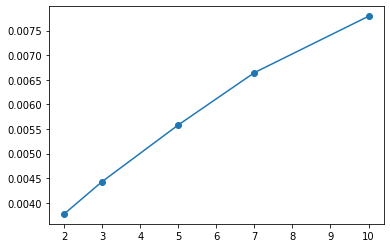

In [13]:
plt.plot(output_time_step,RMSE, marker='o')

In [14]:
MAE

[0.0034756145388240263,
 0.003973542586864453,
 0.004896524176879156,
 0.00573943484351966,
 0.006705801703317484]

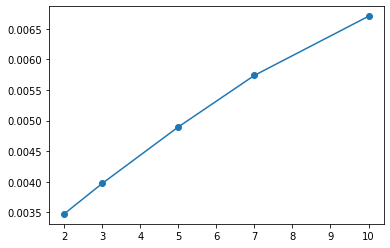

In [15]:
plt.plot(output_time_step,MAE, marker='o')